In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

ModuleNotFoundError: No module named 'fastbook'

### modelzoo to find pretrained models and apply transfer learning

In [21]:
from fastbook import *
from fastai.vision.widgets import *

In [22]:
key = os.environ.get('AZURE_SEARCH_KEY', '6dd5f7148fc44d61a0923adca14bb8d3')

In [23]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [24]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [25]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [30]:
fns = get_image_files(path)
fns

(#324) [Path('bears/grizzly/00000030.jpg'),Path('bears/grizzly/00000029.jpg'),Path('bears/grizzly/00000000.jpg'),Path('bears/grizzly/00000015.jpg'),Path('bears/grizzly/00000034.jpg'),Path('bears/grizzly/00000024.jpg'),Path('bears/grizzly/00000027.jpg'),Path('bears/grizzly/00000002.jpeg'),Path('bears/grizzly/00000033.jpg'),Path('bears/grizzly/00000010.jpg')...]

In [31]:
failed = verify_images(fns)
failed

(#0) []

In [32]:
failed.map(Path.unlink)

(#0) []

### From data to DataLoaders

In [34]:
# data block always returns DataLoaders class
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.3, seed=42),
    get_y = parent_label,
    item_tfms = Resize(128)
)

files get structured so that the category is a folder containing images of the class belonging to that folder

In [35]:
dls = bears.dataloaders(path)

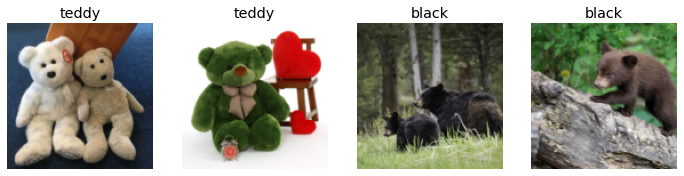

In [39]:
dls.valid.show_batch(max_n = 4, nrows = 1)

### Training model and using it to clean our data

In [46]:
bears = bears.new(
    item_tfms = RandomResizedCrop(224, min_scale=0.5),
    batch_tfms = aug_transforms())
dls = bears.dataloaders(path)

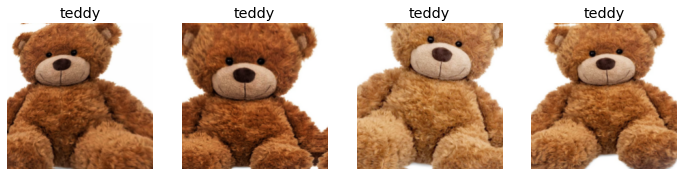

In [48]:
# same teddy, different representation, improves learning, less prone to overfitting - data augmentation
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [49]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.438033,0.224356,0.072165,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.269934,0.070742,0.020619,00:13
1,0.218858,0.040783,0.030928,00:14
2,0.165800,0.032334,0.010309,00:13
3,0.137694,0.035181,0.010309,00:14


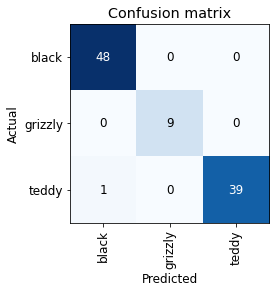

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

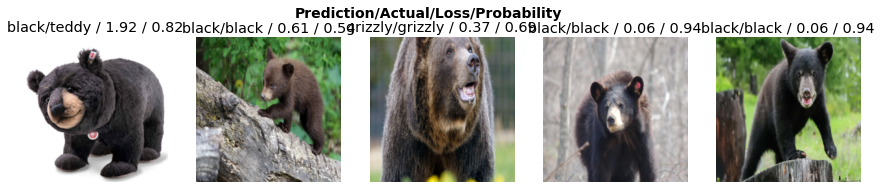

In [53]:
interp.plot_top_losses(5, nrows=1)

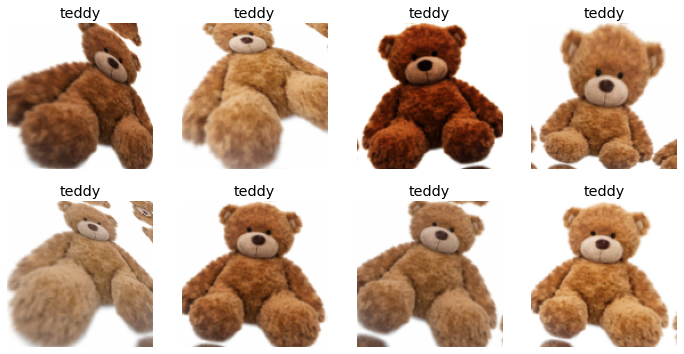

In [51]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n = 8, nrows = 2, unique = True)

In [54]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.795095,2.717814,0.731959,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.590242,1.179837,0.474227,00:14
1,0.487751,0.305068,0.082474,00:14
2,0.373268,0.161889,0.041237,00:14
3,0.299178,0.124677,0.020619,00:14


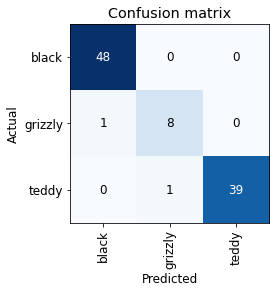

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [57]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [59]:
# voila package to create interactive web notebooks without all the code